In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib, csv, math,sklearn
matplotlib.style.use('seaborn-muted')

from matplotlib import *
from matplotlib import collections as mc
from scipy import stats
import seaborn as sns
from scipy.stats import linregress
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def set_figure_aesthetics(font_scale_, fig_x, fig_y):
    sns.set(font_scale=font_scale_)
    sns.set_style("whitegrid", {'font.serif': [u'helvetica']})
    plt.figure(figsize=(fig_x, fig_y))

---
Plasmid sequencing results
---

In [2]:
BC_df = pd.read_csv('processed_files/BC_correctness_novo.tsv', sep = '\t')
BC_df = BC_df.sort_values(by=['total'], ascending = False)

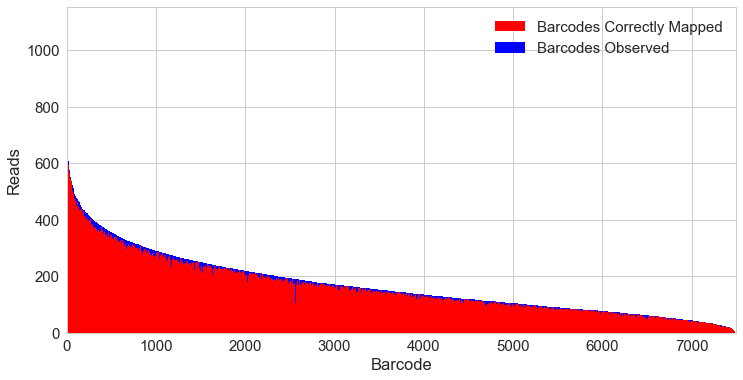

In [3]:
#Plot a histogram of distribution of correct and incorrect barcodes
set_figure_aesthetics(1.5, 12,6)

ind = np.arange(7490)
width = 1
p1 = plt.bar(ind, BC_df.loc[:,'correct'], width, color = 'r', edgecolor = "none")
p2 = plt.bar(ind, BC_df.loc[:,'incorrect'], width, color = 'blue', bottom =BC_df['correct'], edgecolor = "none")
plt.ylabel('Reads');plt.xlabel('Barcode')
plt.legend((p1[0], p2[0]), (('Barcodes Correctly Mapped', 'Barcodes Observed')))
plt.xlim(0,7500)
#plt.savefig('plots/BC_agnostic_map.png')
plt.show()

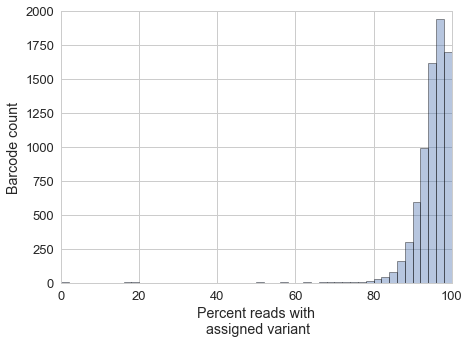

In [4]:
#Figure 2B: A histogram of the percentage of correct reads for each barcode
set_figure_aesthetics(1.3, 7,5)

ax = sns.distplot(BC_df.loc[:,'correct_PCT'], kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=1))
plt.xlim(0,100);plt.ylim(0,2000)
plt.ylabel("Barcode count"); plt.xlabel("Percent reads with\n assigned variant")
#ax.get_figure().savefig("plots/Figure_2B_1o_correct_BC_perecentage_hist.svg",bbox_inches='tight', format = "svg")
#ax.get_figure().savefig("plots/Figure_2B_1o_correct_BC_perecentage_hist.png",bbox_inches='tight')

plt.show()

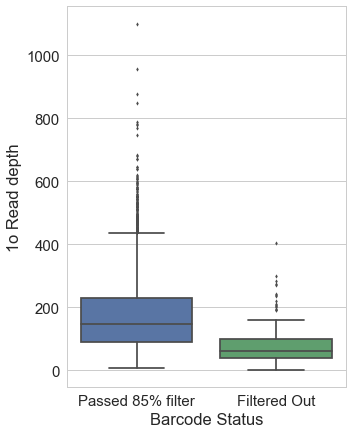

In [5]:
#merge 2o read info which has read depth for plasmid in final configuration
final_config = pd.read_csv('processed_files/2o_barcode_reads.tsv', sep = '\t', names = ['variant', 'BC', '2o read count'], skiprows = 1)
BC_df2 = BC_df.merge(final_config, on = 'BC')

#filter out barcodes without 85% of reads with the correct variant
BC_df2['baddies'] = BC_df2.loc[:,'correct_PCT'] <85
BC_df2.loc[BC_df2['baddies'] == False, 'baddies'] = "Passed 85% filter"
BC_df2.loc[BC_df2['baddies'] == True, 'baddies'] = "Filtered Out"

#filter out barcodes not found in final configuration
BC_df2.loc[BC_df2['2o read count'] == 0, 'baddies'] = "Filtered Out"
set_figure_aesthetics(1.5, 5,7)


#Figure 2C: Filtered out variants have lower read depth
ax = sns.boxplot('baddies', 'total', data = BC_df2, fliersize=3)
plt.ylabel('1o Read depth'); plt.xlabel('Barcode Status')
#ax.get_figure().savefig("plots/Figure_2C_1o_BC_filter_depth.png",bbox_inches='tight')
plt.show()

In [6]:
#Get statistics for error rate and library diversity

baddies = BC_df2[BC_df2.loc[:,'baddies']=="Filtered Out"]
print 'Number of barcodes filtered out: ' + str(len(baddies))
print 'Percentage of barcodes filtered out: ' + str(round(float(len(baddies))/len(BC_df2)*100, 2)) + '%'
#a=open('processed_files/bad_BCs_85.csv', 'wb')
#a.write(','.join(list(baddies['BC'])))
#a.close()

#Error rate :(
print 'Barcode misassignment rate: ' + str(round(float(BC_df2['incorrect'].sum())/(BC_df2['correct'].sum()+BC_df2['incorrect'].sum())*100,2)) + '%'

#skew ratio of top 10% vs bottom 10%; a measure for library diversity
top_10 = np.percentile(BC_df2.loc[:,'2o read count'], 90)
bottom_10 = np.percentile(BC_df2.loc[:,'2o read count'], 10)

print 'Skew ratio: ' + str(top_10/bottom_10)

Number of barcodes filtered out: 136
Percentage of barcodes filtered out: 1.82%
Barcode misassignment rate: 4.59%
Skew ratio: 5.5


---
Read breakdown by sample
---

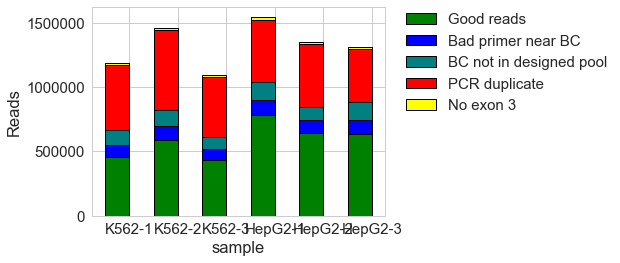

In [7]:
read_dfF = pd.read_csv('processed_files/Read_filtering_breakdown.tsv', sep='\t')

ind = np.arange(6)
width = 0.5
p1 = plt.bar(ind, read_dfF['good_reads'], width, color = 'green', edgecolor="k", linewidth=1)
p2 = plt.bar(ind, read_dfF['bad_primer'], width, color = 'blue', bottom = read_dfF['good_reads'], edgecolor="k", linewidth=1)
p3= plt.bar(ind, read_dfF['BC_foul'], width, color = 'teal', bottom = read_dfF['good_reads'] + read_dfF['bad_primer'], edgecolor="k", linewidth=1)
p4 = plt.bar(ind, read_dfF['PCR_dup'], width, color = 'red', 
             bottom = read_dfF['good_reads'] + read_dfF['bad_primer']+ read_dfF['BC_foul'], edgecolor="k", linewidth=1)
p5 = plt.bar(ind, read_dfF['no_E3'], width, color = 'yellow',
            bottom = read_dfF['good_reads'] + read_dfF['bad_primer']+ read_dfF['BC_foul'] + read_dfF['PCR_dup'], edgecolor="k", linewidth=1)
plt.ylabel('Reads')
plt.xlabel('sample')
plt.xticks(ind + width/2., ('K562-1', 'K562-2', 'K562-3','HepG2-1', 'HepG2-2', 'HepG2-3'))
plt.legend((p1[0], p2[0],p3[0], p4[0], p5[0]), ('Good reads', 'Bad primer near BC', 'BC not in designed pool',
                                               'PCR duplicate', 'No exon 3'),
           bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
plt.tight_layout()
#plt.savefig('plots/read_filtering.png')
plt.show()

---
Correlations between barcode replicates and biological replicates
---

In [8]:
#Read in splice read counts by barcode
splice_BC_df = pd.read_csv('processed_files/splice_results_by_BC.tsv', sep = '\t')

#Filter out bad Barcodes
splice_BC_df = splice_BC_df.merge(BC_df2.loc[:,('BC', 'baddies')], on = 'BC')
splice_BC_df = splice_BC_df[splice_BC_df.loc[:,'baddies'] == 'Passed 85% filter'].dropna()

def get_PSI(sample, df):
    PSI_df = df.loc[:,(sample + '_in', sample + '_out')]
    PSI= PSI_df.loc[:,sample + '_in']/ (PSI_df.loc[:,sample + '_in'] + PSI_df.loc[:,sample + '_out'])*100
    return PSI

No handlers could be found for logger "matplotlib.legend"


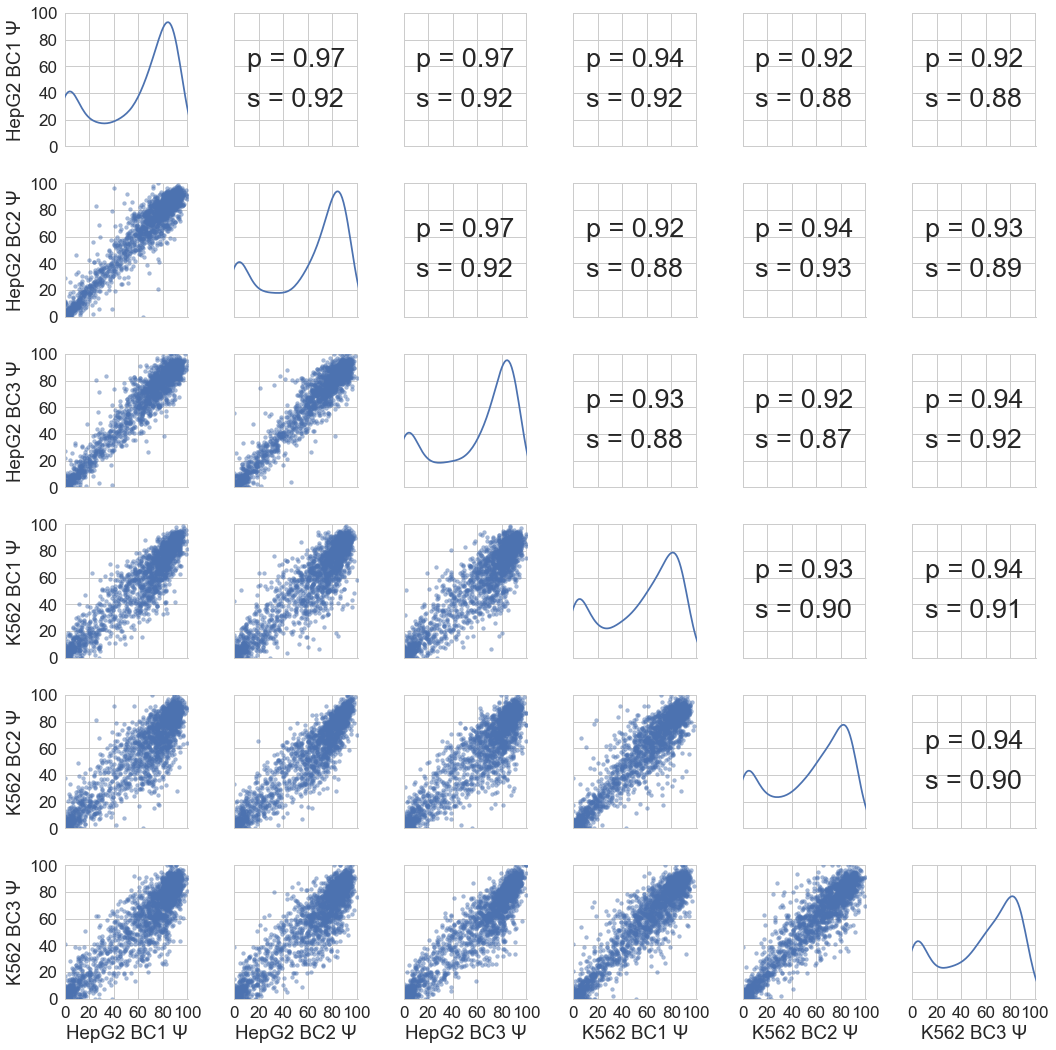

In [9]:
#calculate PSI for each barcode
PSI_BC_df = pd.DataFrame()
PSI_BC_df = splice_BC_df.loc[:,('variant', 'BC')]
for sample in ['H1', 'H2', 'H3', 'K1', 'K2', 'K3']:
    PSI_BC_df[sample] = get_PSI(sample, splice_BC_df)

#Filter out barcodes with no splicing reads
PSI_BC_df = PSI_BC_df.dropna()

#label barcode number for each 
seen_BCs = dict(zip(PSI_BC_df.loc[:,'variant'], [0]*len(PSI_BC_df.loc[:,'BC'])))
BC_number = []
for line in PSI_BC_df.itertuples():
    seen_BCs[line[1]] +=1
    BC_number.append('BC'+ str(seen_BCs[line[1]]))
PSI_BC_df['barcode_number'] = BC_number

#filter out barcode 4 because not all variants have it
PSI_BC_df= PSI_BC_df[PSI_BC_df.loc[:,'barcode_number'] != 'BC4']

#filter out Consensus and Mutated exons
PSI_BC_df = PSI_BC_df[PSI_BC_df.loc[:,'variant'].str.contains("Mutated") == False]
PSI_BC_df = PSI_BC_df[PSI_BC_df.loc[:,'variant'].str.contains("Consensus") == False]

#get average PSI value for each barcode
PSI_BC_df['K_PSI'] = PSI_BC_df.loc[:,('K1', 'K2', 'K3')].mean(axis=1)
PSI_BC_df['H_PSI'] = PSI_BC_df.loc[:,('H1', 'H2', 'H3')].mean(axis=1)

#reformat dataframe
PSI_BC_df = pd.pivot_table(PSI_BC_df.loc[:,('variant','K_PSI', 'H_PSI', 'barcode_number')],
               index='variant', columns='barcode_number').reset_index()
PSI_BC_df = PSI_BC_df.loc[:,'H_PSI'].join(PSI_BC_df.loc[:,'K_PSI'], rsuffix= 'K')
PSI_BC_df.columns = [u"HepG2 BC1 \u03A8", u"HepG2 BC2 \u03A8", u"HepG2 BC3 \u03A8", u"K562 BC1 \u03A8",
                          u"K562 BC2 \u03A8",u"K562 BC3 \u03A8"]

#define spearman and pearson correlation function for graph
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    s, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("p = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes, size=27)
    ax.annotate("s = {:.2f}".format(s),
                xy=(.1, .3), xycoords=ax.transAxes, size=27)

#plot figure 3A
set_figure_aesthetics(1.7, 10, 10)
ax = sns.PairGrid(PSI_BC_df.dropna())
ax.set(xticks=np.arange(0,101,20))
ax.set(yticks=np.arange(0,101,20))
ax.map_lower(plt.scatter, alpha=0.5, s =15)
ax.map_diag(sns.kdeplot)
ax.map_upper(corrfunc)
ax.set(ylim=(0,100));ax.set(xlim=(0,101))
#ax.savefig("plots/Figure_3A_all_sample_PSI_corr_scatter_BC.png",bbox_inches='tight', dpi = 500)
plt.show()

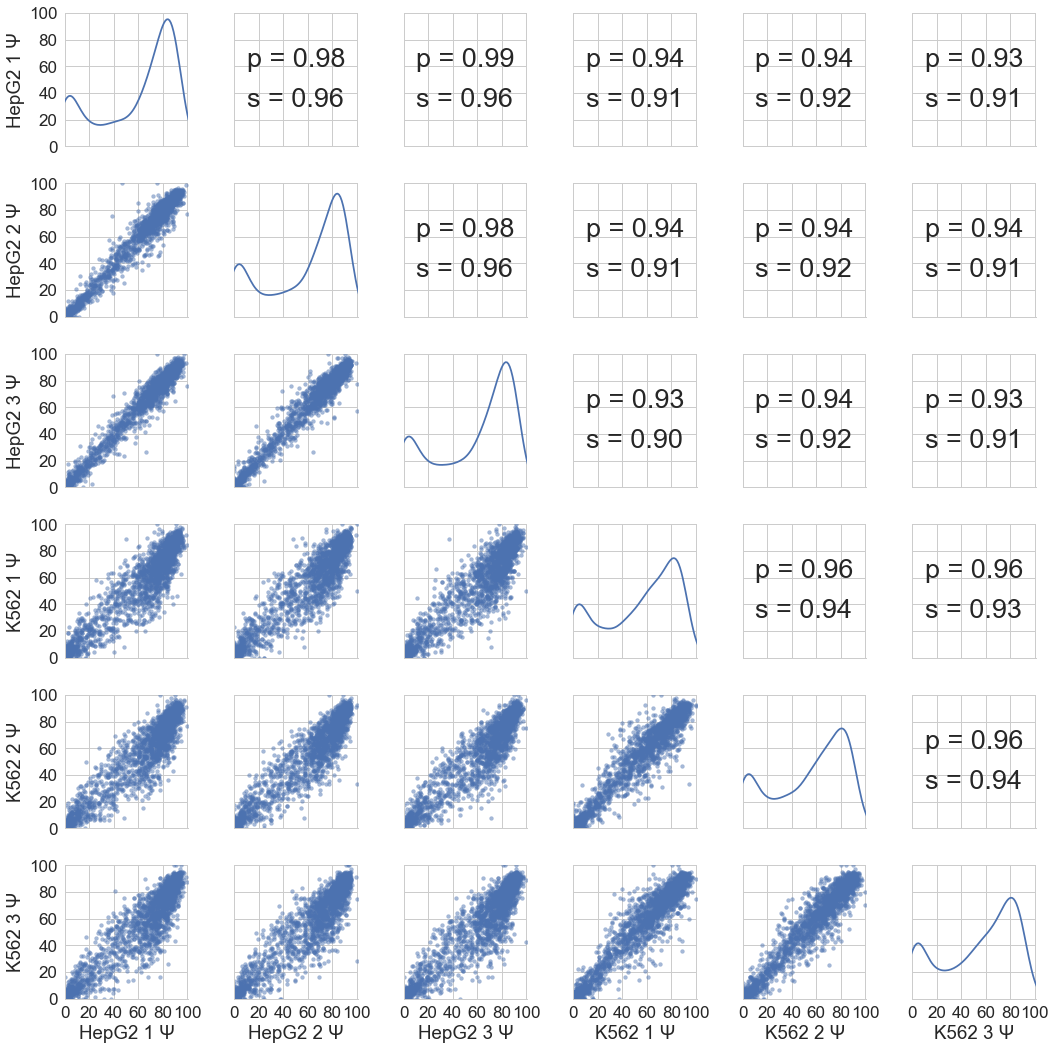

In [10]:
#merge splicing barcode for variants (bad barcodes already filtered out)
bio_corr_df = splice_BC_df.groupby('variant').sum()

#filter out Consensus and Mutated exons
bio_corr_df = bio_corr_df[bio_corr_df.index.str.contains("Mutated") == False]
bio_corr_df = bio_corr_df[bio_corr_df.index.str.contains("Consensus") == False]

#calculate PSI for each biological sample
for sample in ['H1', 'H2', 'H3', 'K1', 'K2', 'K3']:
    bio_corr_df[sample] = get_PSI(sample, bio_corr_df)

#reformat dataframe
bio_corr_df = bio_corr_df.loc[:,('H1', 'H2', 'H3', 'K1', 'K2', 'K3')]
bio_corr_df.columns = [u"HepG2 1 \u03A8", u"HepG2 2 \u03A8", u"HepG2 3 \u03A8", u"K562 1 \u03A8",
                          u"K562 2 \u03A8",u"K562 3 \u03A8"]

#plot figure 3B
set_figure_aesthetics(1.7, 10, 10)
ax = sns.PairGrid(bio_corr_df.dropna())
ax.set(xticks=np.arange(0,101,20))
ax.set(yticks=np.arange(0,101,20))
ax.map_lower(plt.scatter, alpha = 0.5, s =15)
#ax.map_diag(plt.hist, edgecolor="k", linewidth=1)
ax.map_diag(sns.kdeplot)
ax.map_upper(corrfunc)
ax.set(ylim=(0,100));ax.set(xlim=(0,101))
#ax.savefig("plots/Figure_3B_all_sample_PSI_corr_scatter.png",bbox_inches='tight', dpi=500)
plt.show()

---
Distribution of PSI values for controls and variants separately
---

Text(0.5,0,u'Exon Type')

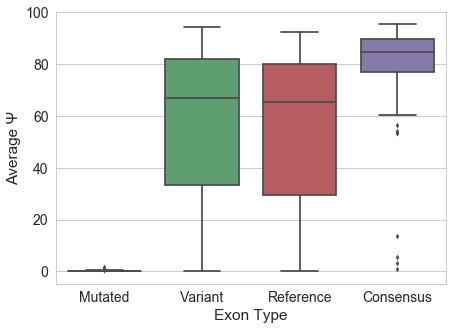

In [11]:
#merge splicing barcode for variants (bad barcodes already filtered out)
exon_cat_df = splice_BC_df.groupby('variant').sum().reset_index()

#calculate PSI for each biological sample
for sample in ['H1', 'H2', 'H3', 'K1', 'K2', 'K3']:
    exon_cat_df[sample] = get_PSI(sample, exon_cat_df)

#classify exons by category
exon_cat_df['class'] = exon_cat_df.loc[:,'variant'].str.split('_').str[3]
new_class = []
for class_ in exon_cat_df.loc[:,'class']:
    if class_ not in ['Mutated', 'Consensus', 'Original']:
        new_class.append('Variant')
    else:
        if class_ != 'Original':
            new_class.append(class_)
        else:
            new_class.append('Reference')
exon_cat_df['class'] = new_class
exon_cat_df['mean_PSI'] = exon_cat_df.loc[:,('H1', 'H2', 'H3', 'K1', 'K2', 'K3')].mean(axis=1)
exon_cat_df['mean_PSI_K'] = exon_cat_df.loc[:,('K1', 'K2', 'K3')].mean(axis=1)
exon_cat_df['mean_PSI_H'] = exon_cat_df.loc[:,('H1', 'H2', 'H3')].mean(axis=1)

#write file with all PSI values
#exon_cat_df.to_csv('processed_files/read_counts_PSI_values.tsv', sep = '\t', index=False)
#PSI values are also available as part of GEO data deposition https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE113163

#Plot PSI by exon types
exon_cat_df = exon_cat_df.dropna()
set_figure_aesthetics(1.4, 7,5)

#Plot Figure 4
order = ['Mutated', 'Variant', 'Reference', 'Consensus']
ax = sns.boxplot(x= 'class', y = 'mean_PSI', data =exon_cat_df, order= order, width = 0.75, fliersize = 4, orient = 'v')
plt.ylabel(u"Average \u03A8"); plt.xlabel("Exon Type")
#ax.get_figure().savefig("plots/Figure_4_Control_PSI_boxplots.svg",bbox_inches='tight' ,format = "svg")
#ax.get_figure().savefig("plots/Figure_4_Control_PSI_boxplots.png",bbox_inches='tight')

---
Similar behavior of variants between HepG2 and K562 cell lines
---

In [12]:
#merge relative splice site position data
relative_splice_pos = pd.read_csv('processed_files/Vex-seq_positions.tsv', sep = '\t')
exon_cat_pos = exon_cat_df.merge(relative_splice_pos)

a=open('processed_files/control_variant_pairs.csv', 'r')
reader = csv.reader(a)
controls = {}
for line in reader:
    control = line[0]
    for variant in line:
        controls[variant] = control
a.close()

#calculate delta PSI
delta_K = []; delta_H = []; delta_PSI = []
for row in exon_cat_pos.iterrows():
    row=row[1]
    variant =row['variant']
    control_row = exon_cat_df[exon_cat_df.loc[:,'variant'] == controls[variant]]
    delta_K.append(float(row['mean_PSI_K'] - control_row['mean_PSI_K']))
    delta_H.append(float(row['mean_PSI_H'] - control_row['mean_PSI_H']))
    delta_PSI.append(np.mean([float(row['mean_PSI_K'] - control_row['mean_PSI_K']),
                              float(row['mean_PSI_H'] - control_row['mean_PSI_H'])]))
    
exon_cat_pos['delta_psi_K'] = delta_K
exon_cat_pos['delta_psi_H'] = delta_H
exon_cat_pos['delta_PSI'] = delta_PSI

#write delta PSI file
#exon_cat_pos.loc[:,('variant', 'mean_PSI', 'mean_PSI_K', 'mean_PSI_H', 'delta_psi_K', 'delta_psi_H',
#                    'delta_PSI')].to_csv('processed_files/delta_PSI_values.tsv', sep = '\t', index=False)

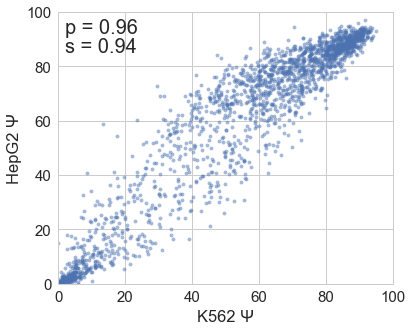

In [13]:
#plot Figure 5A
set_figure_aesthetics(1.5,6,5)
ax = sns.regplot(x='mean_PSI_K', y='mean_PSI_H', data = exon_cat_pos, fit_reg=False, scatter_kws={"s": 15, 'alpha':0.5})
plt.ylim(0,100);plt.xlim(0,100); plt.ylabel(u"HepG2 \u03A8");plt.xlabel(u"K562 \u03A8")

x = exon_cat_pos.loc[:,'mean_PSI_K']; y=exon_cat_pos.loc[:,'mean_PSI_H']
r, _ = stats.pearsonr(x, y)
s, _ = stats.spearmanr(x, y)
ax.annotate("p = {:.2f}".format(r), xy=(0.02, 0.92), xycoords=ax.transAxes, size=20)
ax.annotate("s = {:.2f}".format(s), xy=(0.02, 0.85), xycoords=ax.transAxes, size=20)

#plt.savefig("plots/Figure_5A_cell_line_PSI_corr.png", dpi=300)
plt.show()

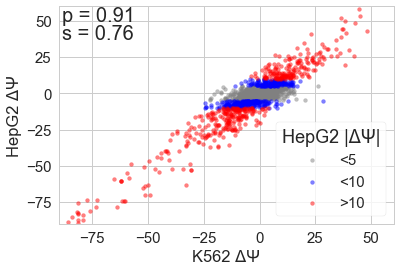

In [14]:
exon_cat_pos0 = exon_cat_pos[abs(exon_cat_pos.loc[:,'delta_psi_H'])<5]
exon_cat_pos5 =exon_cat_pos[abs(exon_cat_pos.loc[:,'delta_psi_H'])>5]
exon_cat_pos5 =exon_cat_pos5[abs(exon_cat_pos5.loc[:,'delta_psi_H'])<10]
exon_cat_pos10 =exon_cat_pos[abs(exon_cat_pos.loc[:,'delta_psi_H'])>10]
#plot Figure 5B
set_figure_aesthetics(1.5,6,5)
fig, ax =plt.subplots()
colors = ['gray','blue', 'red'];thresholds=["<5","<10", ">10"];i=0
for threshold in [exon_cat_pos0,exon_cat_pos5,exon_cat_pos10]:
    plt.scatter(x= threshold.loc[:,'delta_psi_K'], y=threshold.loc[:,'delta_psi_H'], s= 15, alpha = 0.5,
                color = colors[i], label = thresholds[i])
    i+=1

x = exon_cat_pos.loc[:,'delta_psi_K']; y=exon_cat_pos.loc[:,'delta_psi_H']
r, _ = stats.pearsonr(x, y)
s, _ = stats.spearmanr(x, y)
ax.annotate("p = {:.2f}".format(r), xy=(0.01, 0.93), xycoords=ax.transAxes, size=20)
ax.annotate("s = {:.2f}".format(s), xy=(0.01, 0.85), xycoords=ax.transAxes, size=20)

#color things that change more than 5% in hepG2
plt.legend(frameon=True, title = u"HepG2 |\u0394\u03A8|",loc = 'lower right')
plt.ylim(-90,60);plt.xlim(-90,60); plt.ylabel(u"HepG2 \u0394\u03A8");plt.xlabel(u"K562 \u0394\u03A8")
#plt.savefig("plots/Figure_5B_cell_line_delta_PSI_corr_v2.png", dpi=300)
plt.show()

In [15]:
#summary statistics for delta PSI sign agreement
HepG2_sign = np.sign(exon_cat_pos.loc[:,'delta_psi_H'])
K562_sign = np.sign(exon_cat_pos.loc[:,'delta_psi_K'])
sign_counter = 0
for i in range(len(HepG2_sign)):
    if HepG2_sign[i] == K562_sign[i]:
        sign_counter+=1
print 'Same sign of delta PSI for all variants: ' + str(float(sign_counter)/len(HepG2_sign)*100) + '%'

DP5= exon_cat_pos[abs(exon_cat_pos.loc[:,'delta_psi_H']) > 5]
HepG2_sign = np.sign(DP5.loc[:,'delta_psi_H'])
K562_sign = np.sign(DP5.loc[:,'delta_psi_K'])
sign_counter = 0
for i in HepG2_sign.index:
    if HepG2_sign[i] == K562_sign[i]:
        sign_counter+=1
print 'Same sign of delta PSI for |delta PSI| > 5 in HepG2 variants: ' + str(float(sign_counter)/len(HepG2_sign)*100) + '%'

Same sign of delta PSI for all variants: 76.496350365%
Same sign of delta PSI for |delta PSI| > 5 in HepG2 variants: 92.2984356197%


In [16]:
exon_cat_pos['donor_position'] = exon_cat_pos['5SS'].apply(np.int64)
exon_cat_pos['acceptor_position'] = exon_cat_pos['3SS'].apply(np.int64)

#restrict plotting regions for each side of splice site
dfD = exon_cat_pos[exon_cat_pos["5SS"] <=20]
dfD = dfD[dfD["5SS"] >=-33]
dfA = exon_cat_pos[exon_cat_pos["3SS"] <=33]
dfA = dfA[dfA['3SS']>=-50]

Text(0.5,0,u'Variant Position')

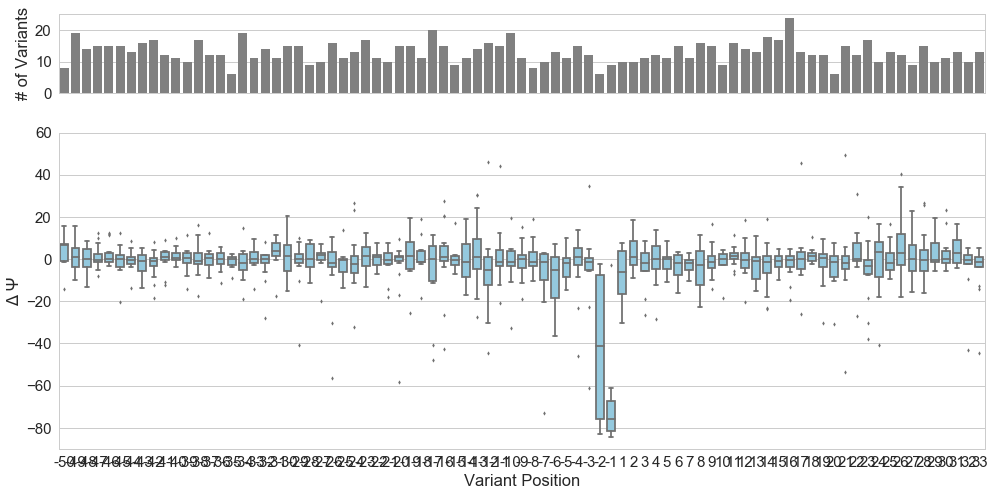

In [17]:
#plot part of Figure 6
set_figure_aesthetics(1.5, 16.6,8)

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 

histax = plt.subplot(gs[0])
histo_series = dfA.loc[:,'3SS'].value_counts().sort_index()
sns.barplot(histo_series.index, histo_series, color = 'gray', ax = histax)
histax.set_ylabel('# of Variants')
histax.set(yticks=np.arange(0,25,10))
plt.setp(histax.get_xticklabels(), visible=False)

axA = plt.subplot(gs[1])
sns.boxplot(x="3SS", y="delta_PSI", data = dfA, fliersize =3, color = 'skyblue', width = 0.7, ax = axA)
plt.ylabel(u"\u0394 \u03A8"); plt.ylim(-90, 60)
plt.xlabel("Variant Position")
#plt.xticks(rotation=60)
#plt.savefig("plots/Figure_6_pt1_3primeSS_boxplot.png")
#plt.savefig('plots/Figure_6_pt1_3primeSS_boxplot.svg', bbox_inches='tight' ,format = "svg")

Text(0.5,0,u'Variant Position')

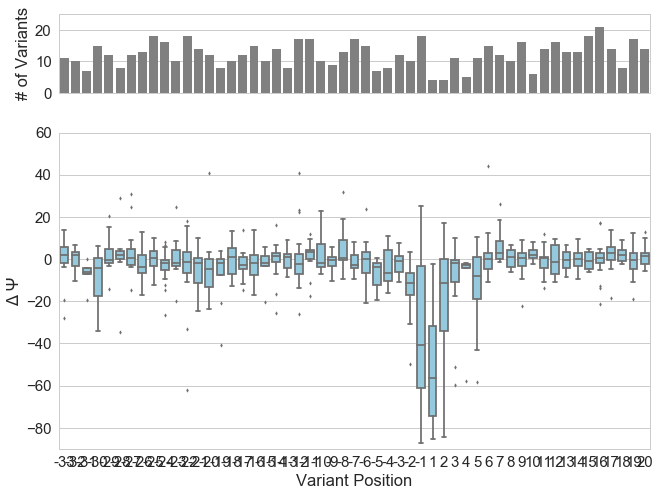

In [18]:
#plot part of Figure 6
set_figure_aesthetics(1.5, 10.6,8)

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 

histax = plt.subplot(gs[0])
histo_series = dfD.loc[:,'5SS'].value_counts().sort_index()
sns.barplot(histo_series.index, histo_series, color = 'gray', ax = histax)
histax.set_ylabel('# of Variants')
histax.set(yticks=np.arange(0,25,10))
histax.set_ylim(0,25)
plt.setp(histax.get_xticklabels(), visible=False)

axD = plt.subplot(gs[1])
axD = sns.boxplot(x="5SS", y="delta_PSI", fliersize =3, data = dfD, color = 'skyblue', width= 0.7, ax = axD)
plt.ylabel(u"\u0394 \u03A8")
plt.ylim(-90, 60)
plt.xlabel("Variant Position")
#plt.xticks(rotation=60)
#plt.savefig("plots/Figure_6_pt2_5primeSS_boxplot.png")
#plt.savefig('plots/Figure_6_pt2_5primeSS_boxplot.svg', bbox_inches='tight' ,format = "svg")

---
Analysis of exonic splicing regulatory elements and splice site strength impacts on splicing
---

[Text(0,0,u'\u0394ESEseq > 0\nn=448'), Text(0,0,u'\u0394ESEseq < 0\nn=589')]

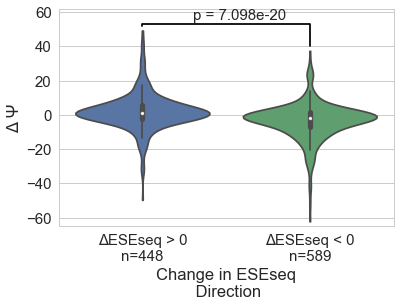

In [19]:
delta_df = exon_cat_pos.loc[:,('variant', 'delta_psi_K', 'delta_psi_H', 'delta_PSI')]
delta_df.columns = ['variant', 'K_delta_psi', 'H_delta_psi', 'delta_PSI']

ESEseq_df= pd.read_csv('processed_files/ESE_seq_changes.tsv', sep = '\t')
ESEseq_df['direction'] = np.where(ESEseq_df.loc[:,'delta_ESEseq']>0, '+', '-')
ESEseq_df.columns = ['variant', 'delta_ESEseq', 'direction']
ESEseq_df = ESEseq_df.merge(delta_df, on='variant')

#Plot figure 7A
ax = sns.violinplot(x='direction', y='delta_PSI', data = ESEseq_df, fliersize=3,cut=0)
plt.ylabel(u"\u0394 \u03A8"); plt.xlabel("Change in ESEseq\n Direction")

ESEseq_pval = stats.mannwhitneyu(ESEseq_df[ESEseq_df.loc[:,'direction'] == '+'].loc[:,'delta_PSI'],
                                ESEseq_df[ESEseq_df.loc[:,'direction'] == '-'].loc[:,'delta_PSI'])[1]

y0 = max(ESEseq_df[ESEseq_df.loc[:,'direction'] == '+'].loc[:,'delta_PSI'])+2.5
y1 = max(ESEseq_df[ESEseq_df.loc[:,'direction'] == '-'].loc[:,'delta_PSI'])+2.5
y2 = 53
ax.plot([0,0,1,1], [y0,y2,y2,y1], color = 'black')
ax.text(0.3, y2+2.5, "p = " + '{:0.3e}'.format(ESEseq_pval), fontsize=15)
plt.ylim(-65,62)

nup="n="+str(len(ESEseq_df[ESEseq_df.loc[:,'direction'] == '+']))
ndown="n="+str(len(ESEseq_df[ESEseq_df.loc[:,'direction'] == '-']))
ax.set_xticklabels([u"\u0394ESEseq > 0\n"+nup, u"\u0394ESEseq < 0\n"+ndown])

#ax.get_figure().savefig("plots/Figure_7A_ESEseq_violinplots.svg",bbox_inches='tight', format = "svg")
#ax.get_figure().savefig("plots/Figure_7A_ESEseq_violinplots.png",bbox_inches='tight')

In [20]:
#Break down hexamers by each variant and setup to compare to ESEseq score
#takes a minute to run ;)
hexamers= pd.read_csv('processed_files/hexamer_ranking.tsv', sep = '\t')
delta_PSIs = []
for row in hexamers.iterrows():
    row = row[1]
    these_deltas = []
    if row['pos_variants'] != '.':
        for variant in row['pos_variants'].split(','):
            these_deltas.append(float(exon_cat_pos[exon_cat_pos.loc[:,'variant'] == variant].loc[:,'delta_PSI']))
    if row['neg_variants'] != '.':
        for variant in row['neg_variants'].split(','):
            these_deltas.append(-float(exon_cat_pos[exon_cat_pos.loc[:,'variant'] == variant].loc[:,'delta_PSI']))
    delta_PSIs.append(np.mean(these_deltas))
hexamers['delta_PSIs'] = delta_PSIs
hexamers = hexamers[np.isfinite(hexamers.loc[:,'delta_PSIs'])]

hex_abund = hexamers.loc[:,'pos_variants'].str.split(',') + hexamers.loc[:,'neg_variants'].str.split(',')
size = []
for item in hex_abund:
    new_len = [x != '.' for x in item].count(True)*4
    size.append(new_len)
hexamers['num_vars'] = size
ESEseq_hexs = pd.read_csv('processed_files/ESEseq_simple.tsv', sep='\t')
hexamers = ESEseq_hexs.merge(hexamers, on = 'hexamer')

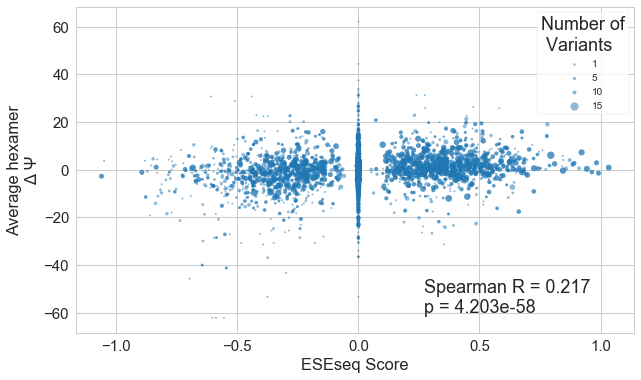

In [21]:
#Plot Figure 7B
color = '#1f77b4'
spearR, spearP = stats.spearmanr(hexamers.loc[:,'ESEseq_score'], hexamers.loc[:,'delta_PSIs'])
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.regplot(hexamers.loc[:,'ESEseq_score'], hexamers.loc[:,'delta_PSIs'], fit_reg=False,
                 scatter_kws={"s": hexamers.loc[:,'num_vars'], 'alpha':0.5, 'color':color})
plt.ylabel(u"Average hexamer\n\u0394 \u03A8"); plt.xlabel("ESEseq Score")
ax.text(0.27, -60, 'Spearman R = '+ str(round(spearR, 3))+'\np = '+ '{:0.3e}'.format(spearP))

# Create some sizes and some labels.
mrk1 = plt.scatter([],[], s=min(hexamers.loc[:,'num_vars']), c =color, alpha = 0.5)
mrk2 = plt.scatter([],[], s=min(hexamers.loc[:,'num_vars'])*2, c =color, alpha = 0.5)
mrk3 = plt.scatter([],[], s=min(hexamers.loc[:,'num_vars'])*3, c =color, alpha = 0.5)
mrk4 = plt.scatter([],[], s=max(hexamers.loc[:,'num_vars']), c =color, alpha = 0.5)
legend_markers = [mrk1,mrk2,mrk3,mrk4]
labels = ['1','5','10','15']
plt.legend(handles = legend_markers, labels = labels, frameon=True, 
           title = 'Number of\n Variants', fontsize =10,bbox_to_anchor=(1, 1))

#ax.get_figure().savefig("plots/Figure_7B_ESEseq_hexamer_correlation.svg",bbox_inches='tight', format = "svg")
#ax.get_figure().savefig("plots/Figure_7B_ESEseq_hexamer_correlation.png",bbox_inches='tight')

Text(0.5,0,u"\u03943'SS Maximum Entropy")

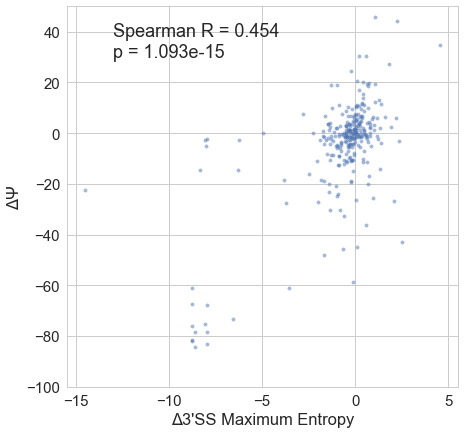

In [22]:
#examine changes in splice site strength
SS_strength = pd.read_csv('processed_files/splice_site_max_ent.tsv', sep='\t')
original_SS = SS_strength[SS_strength.loc[:,'variant'].str.contains('Original')]
original_3 = dict(zip(list(original_SS.loc[:,'variant']), list(original_SS.loc[:,'3_SS'])))
original_5 = dict(zip(list(original_SS.loc[:,'variant']), list(original_SS.loc[:,'5_SS'])))
SS_strength = SS_strength.merge(exon_cat_pos.loc[:,('variant','mean_PSI_K','mean_PSI_H','mean_PSI','delta_psi_K',
                                                   'delta_psi_H','delta_PSI','3SS','5SS')], on = 'variant')
SS_strength['controls'] = SS_strength.loc[:,'variant'].map(controls)
SS_strength['control_3SS'] = SS_strength.loc[:,'controls'].map(original_3)
SS_strength['control_5SS'] = SS_strength.loc[:,'controls'].map(original_5)
SS_strength['delta_3SS'] = SS_strength.loc[:,'3_SS'] - SS_strength.loc[:,'control_3SS']
SS_strength['delta_5SS'] = SS_strength.loc[:,'5_SS'] - SS_strength.loc[:,'control_5SS']

delta_3SS = SS_strength[SS_strength.loc[:,'delta_3SS'] != 0.0]
delta_5SS = SS_strength[SS_strength.loc[:,'delta_5SS'] != 0.0]

#Plot Figure 7C
fig, ax = plt.subplots(figsize = (7,7))
sns.regplot(x = 'delta_3SS', y = 'delta_PSI', data = delta_3SS, scatter_kws={"s": 15, 'alpha':0.5}, fit_reg = False)
spearR, spearP = stats.spearmanr(delta_3SS.loc[:,'delta_3SS'], delta_3SS.loc[:,'delta_PSI'])
ax.text(-13, 30, 'Spearman R = '+ str(round(spearR, 3))+'\np = '+ '{:0.3e}'.format(spearP))
ax.set_ylim(-100,50)

ax.set_ylabel(u"\u0394\u03A8")
ax.set_xlabel(u"\u03943'SS Maximum Entropy")
#fig.savefig("plots/Figure_7C_3SS_MaxEnt_delta_PSI.svg",bbox_inches='tight', format = "svg")
#fig.savefig("plots/Figure_7C_3SS_MaxEnt_delta_PSI.png",bbox_inches='tight')

Text(0.5,0,u"\u03945'SS Maximum Entropy")

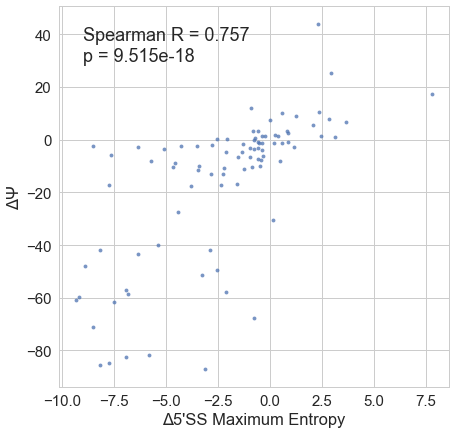

In [23]:
#Plot Figure 7D
fig, ax = plt.subplots(figsize = (7,7))
sns.regplot(x = 'delta_5SS', y = 'delta_PSI', data = delta_5SS, scatter_kws={"s": 15, 'alpha':0.75}, fit_reg = False)
spearR, spearP = stats.spearmanr(delta_5SS.loc[:,'delta_5SS'], delta_5SS.loc[:,'delta_PSI'])
ax.text(-9, 30, 'Spearman R = '+ str(round(spearR, 3))+'\np = '+ '{:0.3e}'.format(spearP))
ax.set_ylabel(u"\u0394\u03A8");ax.set_xlabel(u"\u03945'SS Maximum Entropy")
#fig.savefig("plots/Figure_7D_5SS_MaxEnt_delta_PSI.svg",bbox_inches='tight', format = "svg")
#fig.savefig("plots/Figure_7D_5SS_MaxEnt_delta_PSI.png",bbox_inches='tight',)

---
Breakdown of delta psi by effect prediction
---

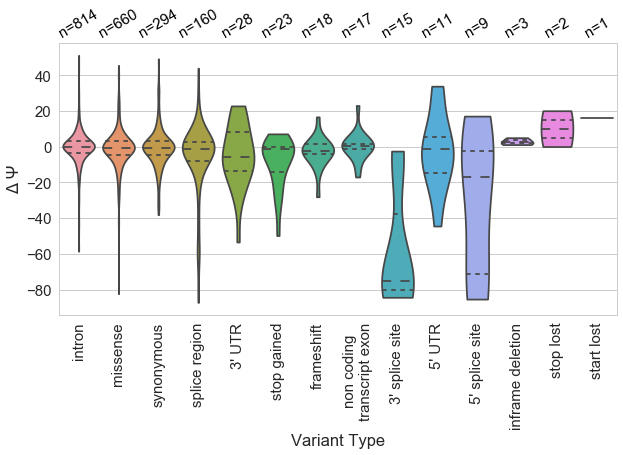

In [24]:
set_figure_aesthetics(1.5, 10,5)
delta_df = exon_cat_pos.loc[:,('variant', 'delta_psi_K', 'delta_psi_H', 'delta_PSI')]
delta_df.columns = ['variant', 'K_delta_psi', 'H_delta_psi', 'delta_PSI']

VEP_df = pd.read_csv('processed_files/68_97_VEP_multiple.tsv', '\t')
delta_df_2 = delta_df.merge(VEP_df, on = 'variant')

dfg = delta_df_2.groupby('annotation')
counts = sorted([len(v) for k, v in dfg], reverse = True)
order = ['intron', 'missense', 'synonymous', 'splice region', "3' UTR", 'stop gained', 'frameshift', 'non coding transcript exon',
           'splice acceptor', "5' UTR", 'splice donor', 'inframe deletion', 'stop lost', 'start lost']
labels = ['intron', 'missense', 'synonymous', 'splice region', "3' UTR", 'stop gained', 'frameshift', 'non coding\ntranscript exon',
           "3' splice site", "5' UTR", "5' splice site", 'inframe deletion', 'stop lost', 'start lost']

#Plot Figure 8
ax = sns.violinplot(x= 'annotation', y = 'delta_PSI', data =delta_df_2, cut =0, scale = "width", order = order,
                   inner="quartiles")
plt.ylabel(u"\u0394 \u03A8"); plt.xlabel("Variant Type")
plt.xticks(range(0,14), labels, rotation=90)

for i in range(0,14):
    plt.text(i, 60, "n="+str(counts[i]), ha='center', va='bottom', color='k', size =15, rotation = 30)
#ax.get_figure().savefig("plots/Figure_8_Annotation_boxplots.svg",bbox_inches='tight', format = "svg")
#ax.get_figure().savefig("plots/Figure_8_Annotation_boxplots.png",bbox_inches='tight')

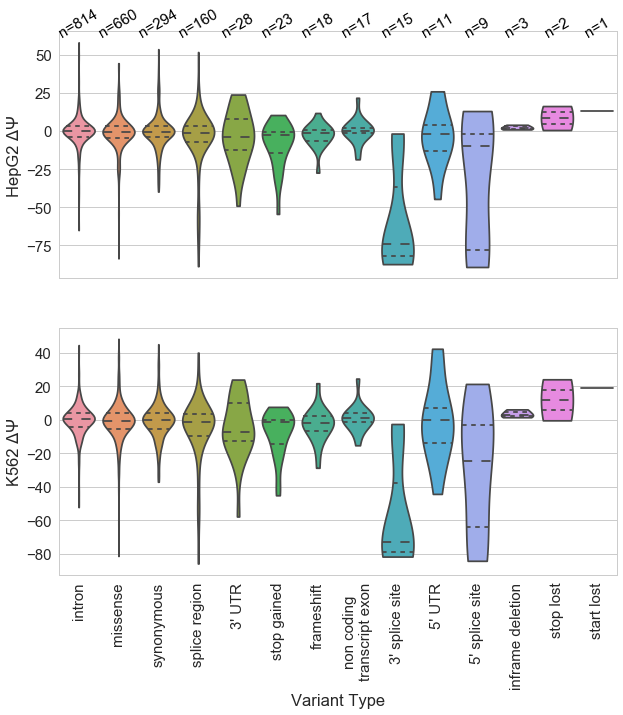

In [25]:
#Alternative version of Figure 8 for each cell line separately
f, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

sns.violinplot(x= 'annotation', y = 'H_delta_psi', data =delta_df_2, order = order, cut =0, scale = "width",
                   inner="quartiles", ax= ax1)
sns.violinplot(x= 'annotation', y = 'K_delta_psi', data =delta_df_2, order = order, cut =0, scale = "width",
                   inner="quartiles", ax= ax2)

ax1.set_ylabel(u"HepG2 \u0394\u03A8");ax2.set_ylabel(u"K562 \u0394\u03A8")
ax2.set_xlabel("Variant Type");ax1.xaxis.set_major_formatter(plt.NullFormatter());ax1.set_xlabel("")
ax1.xaxis.set_major_formatter(plt.NullFormatter())
plt.xticks(range(0,14), labels, rotation=90)

for i in range(0,14):
    ax1.text(i, 60, "n="+str(counts[i]), ha='center', va='bottom', color='k', size =15, rotation = 30)
#ax.get_figure().savefig("plots/Figure_8_alt_Annotation_boxplots.png",bbox_inches='tight')#, format = "svg")

---
Analysis of Conservation of variants with high splicing impacts
---

In [26]:
PhyloP = pd.read_csv('processed_files/68_97_phyloP.tsv', sep = '\t')
PhyloP = PhyloP.merge(delta_df, on = 'variant')
PhyloP = pd.merge(PhyloP, VEP_df, how = 'outer', on =['variant'])
Protein_changers = ['missense', 'stop gain', 'splice donor', 'splice acceptor', 'start lost', 'frameshift', 'inframe deletion']
PhyloP['Prot_change']=''
PhyloP.loc[PhyloP['annotation_no_SR'].isin(Protein_changers) == True, 'Prot_change'] = True
PhyloP.loc[PhyloP['annotation_no_SR'].isin(Protein_changers) == False, 'Prot_change'] =False

PhyloP['impact']=''
PhyloP.loc[abs(PhyloP['delta_PSI']) >=5, 'impact'] = 'high'
PhyloP.loc[abs(PhyloP['delta_PSI']) <5, 'impact'] = 'low'

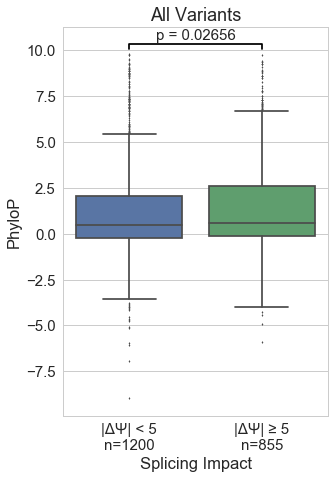

In [27]:
MWU_p_all =  stats.mannwhitneyu(PhyloP[PhyloP['impact'] == 'high']['PhyloP'],
                                PhyloP[PhyloP['impact'] == 'low']['PhyloP'])[1]
set_figure_aesthetics(1.5, 5,7)

#Plot figure 9A
ax = sns.boxplot(x='impact', y = 'PhyloP', data = PhyloP.dropna(), fliersize=2)
y1 = max(PhyloP['PhyloP'])+0.25; y2 = max(PhyloP['PhyloP'])+0.5
ax.plot([0,0,1,1], [y1,y2,y2,y1], color = 'black')
ax.text(0.2, y2+0.25, "p = " + str(round(MWU_p_all, 5)), fontsize=15)
ax.set_title('All Variants')

nlow="n="+str(len(PhyloP[PhyloP['impact']=='low']))
nhigh="n="+str(len(PhyloP[PhyloP['impact']=='high']))
ax.set_xticklabels([u"|\u0394\u03A8| < 5\n"+nlow, u"|\u0394\u03A8| \u2265 5\n"+nhigh])
ax.set_xlabel('Splicing Impact')

plt.tight_layout()
#plt.savefig("plots/Figure_9A_PhyloP_delta_PSI_all_variants_update.svg",bbox_inches='tight', format = "svg")
#plt.savefig("plots/Figure_9A_PhyloP_delta_PSI_all_variants_update.png",bbox_inches='tight')

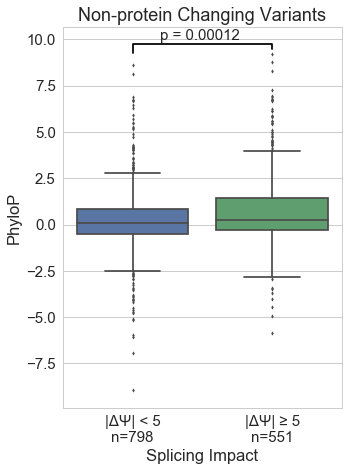

In [28]:
PhyloP_same_prot = PhyloP[PhyloP['Prot_change']==False]
MWU_p_same_prot =  stats.mannwhitneyu(PhyloP_same_prot[PhyloP_same_prot['impact'] == 'high']['PhyloP'],
                                      PhyloP_same_prot[PhyloP_same_prot['impact'] == 'low']['PhyloP'])[1]
#Plot figure 9B
set_figure_aesthetics(1.5, 5,7)
ax = sns.boxplot(x='impact', y = 'PhyloP', data = PhyloP_same_prot.dropna(), fliersize=3)
y0 = 9.25; y1 = max(PhyloP_same_prot['PhyloP'])+0.25; y2 = max(PhyloP_same_prot['PhyloP'])+0.5
ax.plot([0,0,1,1], [y0,y2,y2,y1], color = 'black')
ax.text(0.2, y2+0.25, "p = " + str(round(MWU_p_same_prot, 5)), fontsize=15)
ax.set_title('Non-protein Changing Variants')

nlow="n="+str(len(PhyloP_same_prot[PhyloP_same_prot['impact']=='low']))
nhigh="n="+str(len(PhyloP_same_prot[PhyloP_same_prot['impact']=='high']))
ax.set_xticklabels([u"|\u0394\u03A8| < 5\n"+nlow, u"|\u0394\u03A8| \u2265 5\n"+nhigh])
ax.set_xlabel('Splicing Impact')
#plt.savefig("plots/Figure_9B_PhyloP_delta_PSI_same_prot_update.svg",bbox_inches='tight', format = "svg")
#plt.savefig("plots/Figure_9B_PhyloP_delta_PSI_same_prot_update.png",bbox_inches='tight')

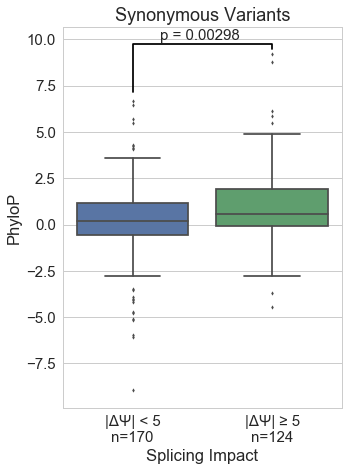

In [29]:
PhyloP_synon = PhyloP[PhyloP['annotation']=='synonymous']

MWU_p_synon =  stats.mannwhitneyu(PhyloP_synon[PhyloP_synon['impact'] == 'high']['PhyloP'],
                                      PhyloP_synon[PhyloP_synon['impact'] == 'low']['PhyloP'])[1]
#Plot figure 9C
set_figure_aesthetics(1.5, 5,7)
ax = sns.boxplot(x='impact', y = 'PhyloP', data = PhyloP_synon.dropna(), fliersize=3)
y0 = max(PhyloP_synon[PhyloP_synon['impact'] == 'low']['PhyloP'])+0.5
y1 = max(PhyloP_synon['PhyloP'])+0.25; y2 = max(PhyloP_synon['PhyloP'])+0.5
ax.plot([0,0,1,1], [y0,y2,y2,y1], color = 'black')
ax.text(0.2, y2+0.25, "p = " + str(round(MWU_p_synon, 5)), fontsize=15)
ax.set_title('Synonymous Variants')

nlow="n="+str(len(PhyloP_synon[PhyloP_synon['impact']=='low']))
nhigh="n="+str(len(PhyloP_synon[PhyloP_synon['impact']=='high']))
ax.set_xticklabels([u"|\u0394\u03A8| < 5\n"+nlow, u"|\u0394\u03A8| \u2265 5\n"+nhigh])

ax.set_xlabel('Splicing Impact')
#plt.savefig("plots/Figure_9C_PhyloP_delta_PSI_synonymous_update.svg",bbox_inches='tight', format = "svg")
#plt.savefig("plots/Figure_9C_PhyloP_delta_PSI_synonymous_update.png",bbox_inches='tight')

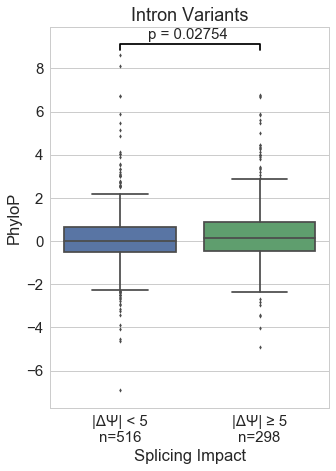

In [30]:
PhyloP_intron = PhyloP[PhyloP['annotation']=='intron']

MWU_p_intron =  stats.mannwhitneyu(PhyloP_intron[PhyloP_intron['impact'] == 'high']['PhyloP'],
                                      PhyloP_intron[PhyloP_intron['impact'] == 'low']['PhyloP'])[1]
#Plot figure 9D
set_figure_aesthetics(1.5, 5,7)
ax = sns.boxplot(x='impact', y = 'PhyloP', data = PhyloP_intron.dropna(), fliersize=3)
y0 = max(PhyloP_intron[PhyloP_intron['impact'] == 'low']['PhyloP'])+0.25
y1 = max(PhyloP_intron['PhyloP'])+0.25; y2 = max(PhyloP_intron['PhyloP'])+0.5
ax.plot([0,0,1,1], [y0,y2,y2,y1], color = 'black')
ax.text(0.2, y2+0.25, "p = " + str(round(MWU_p_intron, 5)), fontsize=15)
ax.set_title('Intron Variants')

nlow="n="+str(len(PhyloP_intron[PhyloP_intron['impact']=='low']))
nhigh="n="+str(len(PhyloP_intron[PhyloP_intron['impact']=='high']))
ax.set_xticklabels([u"|\u0394\u03A8| < 5\n"+nlow, u"|\u0394\u03A8| \u2265 5\n"+nhigh])

ax.set_xlabel('Splicing Impact')
#plt.savefig("plots/Figure_9D_PhyloP_delta_PSI_intron_update.svg",bbox_inches='tight', format = "svg")
#plt.savefig("plots/Figure_9D_PhyloP_delta_PSI_intron_update.png",bbox_inches='tight')

---
Analysis of NMD on splicing behavior
---

Total significant splicing changes: 151
Significant splicing changes which increase inclusion: 149
Significant changes with a PTC: 95


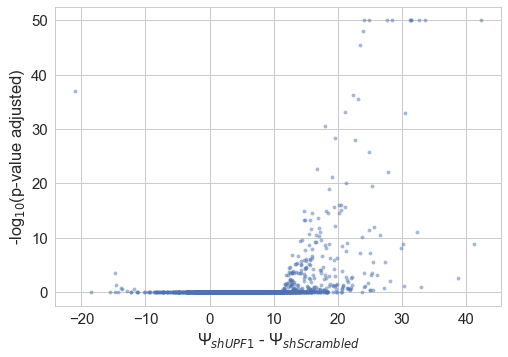

In [31]:
#Plot figure 10B
K562_rmats = pd.read_csv('processed_files/K562_UPF1_KD_rMATS_output.tsv', sep = '\t')
K562_rmats['-log10Padj'] = -K562_rmats.loc[:,'FDR'].apply(math.log10)
K562_rmats['-log10Padj'] = K562_rmats.loc[:,'-log10Padj'].clip(upper = 50)
K562_rmats = K562_rmats[K562_rmats.loc[:,'Exon'].str.contains("Control") == False]

ax = sns.regplot(K562_rmats.loc[:,'delta_PSI'],K562_rmats.loc[:,'-log10Padj'],fit_reg=False, scatter_kws={"s": 15, 'alpha':0.5})

plt.ylabel("-log" + r'$_{10}$' +"(p-value adjusted)"); plt.xlabel(u"\u03A8" + r'$_{shUPF1}$ - ' + u"\u03A8" + r'$_{shScrambled}$')
#ax.get_figure().savefig("plots/Figure_10B_UPF1_rMATs-STAT_volcano_plot.png",bbox_inches='tight')#, format = "svg")
#ax.get_figure().savefig("plots/Figure_10B_UPF1_rMATs-STAT_volcano_plot.svg",bbox_inches='tight', format = "svg")


#Directionality of significant splicing events
PTC_df = pd.read_csv('processed_files/68_97_premature_stop_codons_50_nucs.tsv', sep = '\t')
PTC_df.columns = ['Exon', 'PTC']
K562_rmats = K562_rmats.merge(PTC_df, on = 'Exon')
sigs = K562_rmats[K562_rmats.loc[:,'FDR']<0.01]
print 'Total significant splicing changes: ' + str(len(sigs))
print 'Significant splicing changes which increase inclusion: '+ str(len(sigs[sigs.loc[:,'delta_PSI']>0]))
print 'Significant changes with a PTC: ' + str(len(sigs[sigs.loc[:,'PTC']=='yes']))

In [32]:
PTC_df = pd.read_csv('processed_files/68_97_premature_stop_codons_50_nucs.tsv', sep = '\t')
PTC_df.columns = ['variant', 'PTC']
K562_UPF1_PSI = pd.read_csv('processed_files/K562_UPF1_splice_results_BC_filtered.tsv', sep = '\t').dropna()
K562_UPF1_PSI = K562_UPF1_PSI[K562_UPF1_PSI.loc[:,'variant'].str.contains("Consensus") == False]
K562_UPF1_PSI = K562_UPF1_PSI[K562_UPF1_PSI.loc[:,'variant'].str.contains("Mutated") == False]
K562_UPF1_PSI = K562_UPF1_PSI.merge(PTC_df, on ='variant')

PTC_df = pd.read_csv('processed_files/68_97_diff_NMD.tsv', sep = '\t')
PTC_diff = PTC_df[PTC_df.loc[:,'PTC'] != PTC_df.loc[:,'ref_PTC']].loc[:,'variant']

sc_PSI=[];KD_PSI=[]
for sample in ['s1','s2','s3','KD1','KD2','KD3']:
    K562_UPF1_PSI.loc[:,'K'+sample+'_weight'] = K562_UPF1_PSI.loc[:,'K'+sample+'_in'] + K562_UPF1_PSI.loc[:,'K'+sample+'_out']
for row in K562_UPF1_PSI.iterrows():
    row = row[1]
    sc_PSI.append(np.average(row[['Ks1_PSI','Ks2_PSI','Ks3_PSI']],
                             weights = row[['Ks1_weight','Ks2_weight','Ks3_weight']]))
    KD_PSI.append(np.average(row[['KKD1_PSI','KKD2_PSI','KKD3_PSI']],
                             weights = row[['KKD1_weight','KKD2_weight','KKD3_weight']]))
K562_UPF1_PSI['Ks_PSI'] = sc_PSI
K562_UPF1_PSI['KKD_PSI'] = KD_PSI
#calculate delta PSI
delta_sc =[]; delta_KD =[];to_drop = []
for row in K562_UPF1_PSI.iterrows():
    row = row[1]
    variant =row['variant']
    if variant in controls:
        control_row =  K562_UPF1_PSI[ K562_UPF1_PSI.loc[:,'variant'] == controls[variant]]
        delta_sc.append(float(row['Ks_PSI']) - float(control_row['Ks_PSI']))
        delta_KD.append(float(row['KKD_PSI']) - float(control_row['KKD_PSI']))
    else:
        to_drop.append(variant)

K562_UPF1_PSI = K562_UPF1_PSI[K562_UPF1_PSI.loc[:,'variant'].isin(to_drop) == False]
K562_UPF1_PSI.loc[:,'Ks_delta_PSI'] = delta_sc
K562_UPF1_PSI.loc[:,'KKD_delta_PSI'] = delta_KD
K562_UPF1_PSI.loc[:,'change_in_delta_PSI'] = K562_UPF1_PSI.loc[:,'Ks_delta_PSI'] - K562_UPF1_PSI.loc[:,'KKD_delta_PSI']
#K562_UPF1_PSI


(0.84908189945867407, 0.0)
SpearmanrResult(correlation=0.65762617318042649, pvalue=2.9945518852636036e-268)


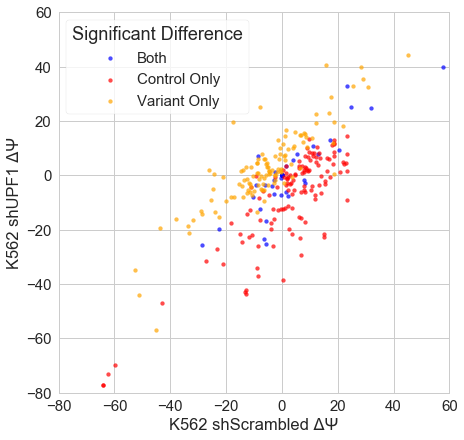

In [33]:
x = K562_UPF1_PSI.loc[:,'Ks_delta_PSI']; y = K562_UPF1_PSI.loc[:,'KKD_delta_PSI']
K562_rmats = pd.read_csv('processed_files/K562_UPF1_KD_rMATS_output.tsv', sep = '\t')
sigs = K562_rmats[K562_rmats.loc[:,'FDR']<=0.01]

test_df = K562_UPF1_PSI
test_df['control'] = test_df.loc[:,'variant'].map(controls)

c_sigs = list(test_df[test_df.loc[:,'control'].isin(sigs.loc[:,'Exon'])].loc[:,'variant'])
v_sigs = list(test_df[test_df.loc[:,'variant'].isin(sigs.loc[:,'Exon'])].loc[:,'variant'])

colors=[];color_map = dict(zip(['blue', 'red', 'orange','gray'], ['Both', 'Control Only', 'Variant Only', 'None']))
for row in test_df.iterrows():
    row=row[1]
    if row['variant'] in c_sigs:
        if row['variant'] in v_sigs:
            colors.append('blue')
        else:
            colors.append('red')
    elif row['variant'] in v_sigs:
        colors.append('orange')
    else:
        colors.append('gray')
test_df['colors'] = colors


#Plot Figure 10C
print stats.pearsonr(x,y)
print stats.spearmanr(x,y)
fig, ax = plt.subplots(figsize = (7,7))

#alternate to plot non-significant events too:
#for color in ['blue', 'red', 'orange', 'gray']:
for this_color in ['blue', 'red', 'orange']:
    this_df = test_df[test_df.loc[:,'colors'] == this_color]
    plt.scatter(this_df.loc[:,'Ks_delta_PSI'], this_df.loc[:,'KKD_delta_PSI'], color = this_color,
                label = color_map[this_color], s=15, alpha = 0.7)
plt.legend(frameon=True, title = 'Significant Difference',loc = 'upper left')
plt.ylabel(u"K562 shUPF1 \u0394\u03A8");plt.xlabel(u"K562 shScrambled \u0394\u03A8")
plt.xlim(-80, 60);plt.ylim(-80, 60)
set_figure_aesthetics(1.4, 10,10)
#fig.savefig("plots/Figure_10C_UPF1_Scram_scatter.svg",bbox_inches='tight', format = "svg")
#fig.savefig("plots/Figure_10C_UPF1_Scram_scatter.png",bbox_inches='tight')

In [34]:
#Run linear regression to predict NMD behavior
K562_UPF1_PSI['weights_sc'] = K562_UPF1_PSI.loc[:,('Ks1_in','Ks1_out','Ks2_in','Ks2_out','Ks3_in','Ks3_out')].sum(axis=1)
K562_UPF1_PSI['weights_KD'] = K562_UPF1_PSI.loc[:,('KKD_in','KKD_out','KKD2_in','KKD2_out','KKD3_in','KKD3_out')].sum(axis=1)
weights = K562_UPF1_PSI.loc[:,('weights_sc', 'weights_KD')].min(axis=1)

#split data into 2/3s training and 1/3 testing
weights_traina, weights_trainb, weights_test = np.array_split(weights,3)
X = K562_UPF1_PSI.loc[:,('KKD_PSI', 'PTC')]
PTC_map = {'yes':1, 'no':0}
X['PTC'] = X.loc[:,'PTC'].map(PTC_map)
Xa = X

#predict the behavior of PTC containing test exons WT cells from the splicing behavior in NMD attenuated cells
y = K562_UPF1_PSI.loc[:,'Ks_PSI']
X_traina, X_trainb , X_test = np.array_split(X,3)
y_traina, y_trainb , y_test = np.array_split(y,3)
X_train = pd.concat([X_traina,X_trainb])
y_train = pd.concat([y_traina,y_trainb])
weights_train = pd.concat([weights_traina,weights_trainb])

X_testa=X_test

regrF = linear_model.LinearRegression()
regrF.fit(X_train, y_train, sample_weight = weights_train)
y_preda = regrF.predict(X_test)
regrF.coef_

array([ 0.96137547, -3.88406886])

Full Model
	Mean squared error: 47.83
		PTC only:73.3523030587
	Variance score: 0.94
		PTC only:0.905828520768
10-fold cross validation score: 0.927546997046
Reduced model
	Mean squared error: 58.58
		PTC only:98.6454328161
	Variance score: 0.93
		PTC only:0.873356582679


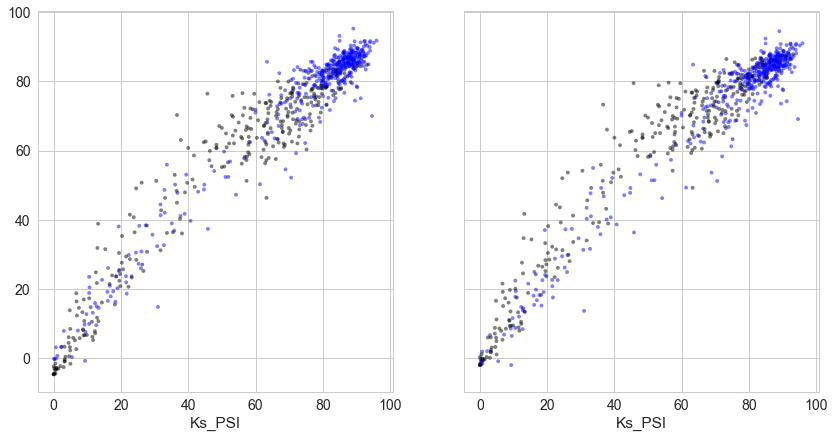

In [35]:
X = K562_UPF1_PSI.loc[:,'KKD_PSI']
X_traina, X_trainb , X_test = np.array_split(X,3)
X_train = np.concatenate([X_traina,X_trainb]).reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
color_map = {1:'black', 0:'blue'}

#regr = svm.SVR(C=0.1,epsilon = 0.5)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train,sample_weight = weights_train)
y_pred = regr.predict(X_test)

predicted_df = pd.DataFrame({'y_test': y_test, 'Full_pred':y_preda, 'reduced_pred':y_pred})
predicted_df = predicted_df.join(X_testa)
PTC_only_pred = predicted_df[predicted_df.loc[:,'PTC']==1]

print "Full Model"
print("\tMean squared error: %.2f"
      % mean_squared_error(y_test, y_preda))
print "\t\tPTC only:" +str(mean_squared_error(PTC_only_pred.loc[:,'y_test'], PTC_only_pred.loc[:,'Full_pred']))
print('\tVariance score: %.2f' % r2_score(y_test, y_preda))
print "\t\tPTC only:" + str(r2_score(PTC_only_pred.loc[:,'y_test'], PTC_only_pred.loc[:,'Full_pred']))
print '10-fold cross validation score: ' + str(np.mean(sklearn.model_selection.cross_val_score(regrF, Xa, y,cv=10)))
print "Reduced model"
print("\tMean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print "\t\tPTC only:" +str(mean_squared_error(PTC_only_pred.loc[:,'y_test'], PTC_only_pred.loc[:,'reduced_pred']))
print('\tVariance score: %.2f' % r2_score(y_test, y_pred))
print "\t\tPTC only:" + str(r2_score(PTC_only_pred.loc[:,'y_test'], PTC_only_pred.loc[:,'reduced_pred']))
#print np.mean(sklearn.model_selection.cross_val_score(regr, X.reshape(-1, 1), y,cv=10))

fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(14,7))
sns.regplot(y_test, y_preda,fit_reg=False,
            scatter_kws={"s": 15, 'alpha':0.5,"color":list(X_testa.loc[:,'PTC'].map(color_map))}, ax = ax1)
sns.regplot(y_test, y_pred,fit_reg=False,
            scatter_kws={"s": 15, 'alpha':0.5,"color":list(X_testa.loc[:,'PTC'].map(color_map))}, ax = ax2)
#fig.savefig('plots/NMD_regression_plots.png')